In [28]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.svm import SVR

In [29]:
df = pd.read_parquet('./anon_processed_df_parquet.parquet', engine='pyarrow')

In [30]:
df.describe()

,steps_awake_mean,sleep_asleep_weekday_mean,sleep_asleep_weekend_mean,sleep_in_bed_weekday_mean,sleep_in_bed_weekend_mean,sleep_ratio_asleep_in_bed_weekday_mean,sleep_ratio_asleep_in_bed_weekend_mean,sleep_in_bed_iqr,sleep_asleep_iqr,sleep_ratio_asleep_in_bed_iqr,...,life_stress,med_nonmed_dnu,life_activity_eating,life_red_stop_alcoh,comorbid_neuropathic,comorbid_arthritis,phq9_score_start,phq9_score_end,phq9_cat_end,phq9_cat_start
count,35674.000000,35329.000000,34301.000000,35329.000000,34301.000000,34123.000000,32260.000000,22228.000000,22228.000000,15532.000000,...,35694.000000,35694.000000,35694.000000,35694.000000,35694.000000,35694.000000,10866.000000,10866.000000,10866.000000,10866.000000
mean,8471.100429,364.581904,397.398778,412.144136,449.207385,0.887317,0.886492,115.704888,103.586243,0.040923,...,0.039278,0.489634,0.183476,0.040679,0.302012,0.297753,7.661881,7.467605,1.116602,1.155255
std,4267.165345,128.895531,162.401119,132.488135,170.465514,0.129016,0.132958,84.720396,75.534577,0.032043,...,0.194259,0.499900,0.387062,0.197548,0.579062,0.512623,6.028646,6.037733,1.159894,1.168189
min,49.285714,0.000000,0.000000,0.000000,0.000000,0.088608,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5605.931319,310.916667,312.500000,380.916667,393.000000,0.909928,0.902172,64.250000,58.750000,0.022577,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,3.000000,0.000000,0.000000
50%,7847.952381,397.333333,432.500000,441.916667,483.000000,0.933812,0.933658,95.250000,85.250000,0.031693,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,6.000000,1.000000,1.000000
75%,10501.750000,448.250000,503.500000,487.750000,550.000000,0.951378,0.955775,138.750000,123.250000,0.045741,...,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,11.000000,11.000000,2.000000,2.000000
max,52048.928571,1085.000000,1250.000000,1085.000000,1400.000000,1.000000,1.000000,764.750000,714.750000,0.511468,...,1.000000,1.000000,1.000000,1.000000,3.000000,2.000000,27.000000,27.000000,4.000000,4.000000


Drop every row that doesn't have a completed phq9 survey.

In [3]:
phq9_columns = [col for col in df.columns if col.startswith('phq9')]
df = df.dropna(subset=phq9_columns)

One hot encoding for categorical features

In [4]:
categorical_columns = df.select_dtypes(include=['object', 'category']).columns
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

Analyzing missing data

In [5]:
missing_percentage = df.isnull().mean() * 100
missing_data = missing_percentage[missing_percentage > 0]
overall_missing_percentage = df.isnull().mean().mean() * 100
print(f"Overall Missing Data Percentage: {overall_missing_percentage:.2f}%")

Overall Missing Data Percentage: 14.08%


In [6]:
missing_summary = df.isnull().sum()
missing_summary = missing_summary[missing_summary > 0].sort_values(ascending=False)
print(missing_summary)
#to_string()

steps_mvpa_iqr                       9417
steps__mvpa__sum__coeff_             8252
steps__mvpa__sum__intercept_         8252
steps__mvpa__sum__score_             8252
sleep_ratio_asleep_in_bed_iqr        6278
                                     ... 
height                                  4
weight                                  2
steps__not_moving__sum__intercept       2
steps__not_moving__sum__score           2
steps__not_moving__sum__coeff           2
Length: 111, dtype: int64


In [7]:
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
from scipy.stats import zscore

df_zscores = df[numerical_columns].apply(zscore)

outliers_zscore = (df_zscores > 3) | (df_zscores < -3)
df_cleaned_zscore = df[~outliers_zscore.any(axis=1)]



Checking remaining rows amount

In [8]:
print(df.shape[0])

10866


## KNN Imputing

### Examine and choose best k

In [9]:
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

test_df_missing = test_df.copy()
test_df_missing.iloc[0, 1] = np.nan

errors = {}
for n in range(1, 6):
    imputer = KNNImputer(n_neighbors=n)
    train_imputed = imputer.fit_transform(train_df)
    test_imputed = imputer.transform(test_df_missing)

    error = mean_squared_error(test_df.dropna(), test_imputed[:len(test_df.dropna())])
    errors[n] = error

best_n = min(errors, key=errors.get)
print(f"Best n_neighbors: {best_n}")
print("Errors:", errors)

Best n_neighbors: 3
Errors: {1: 572026.4297817793, 2: 559539.0561581698, 3: 557655.856913134, 4: 558559.0388311545, 5: 558098.3075812126}


### Do Imputing with best k

In [10]:
imputer = KNNImputer(n_neighbors=best_n)
imputed_data = imputer.fit_transform(df)

In [11]:
df = pd.DataFrame(imputed_data, columns=df.columns)

In [12]:
imputedbackup = df.copy()

## Cleanup features - choose features based on correlation

In [13]:
df = imputedbackup.copy()

### PCA

In [14]:


X = df.drop(columns=['phq9_score_end'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=X.shape[1])
pca.fit(X_scaled)

loadings = np.abs(pca.components_)

threshold = 0.5
important_features = np.any(loadings > threshold, axis=0)
selected_columns = X.columns[important_features]

df_reduced = df[selected_columns.tolist() + ['phq9_score_end']]

print("Important Features:\n", selected_columns, len(selected_columns))


Important Features:
 Index(['steps_awake_mean', 'sleep_ratio_asleep_in_bed_weekday_mean',
       'sleep_ratio_asleep_in_bed_weekend_mean', 'sleep_in_bed_iqr',
       'sleep_asleep_iqr', 'sleep_ratio_asleep_in_bed_iqr', 'steps_mvpa_iqr',
       'sleep__hyposomnia_count_', 'steps__active_day_count_',
       'steps__sedentary_day_count_', 'steps__awake__sum__score',
       'steps__awake__sum__intercept', 'steps__awake__sum__coeff',
       'steps__mvpa__sum__intercept', 'steps__light_activity__sum__intercept',
       'sleep__nap_count__score', 'sleep__total_asleep_minutes__intercept',
       'sleep__main_efficiency__score', 'sleep__main_efficiency__intercept',
       'sleep__main_efficiency__coeff', 'sleep__awake__sum__score',
       'sleep__awake__sum__intercept', 'sleep__awake__sum__coeff',
       'sleep__total_in_bed_minutes__intercept',
       'sleep__total_in_bed_minutes__coeff',
       'sleep_ratio_asleep_in_bed__coeff', 'steps__awake__sum__score_',
       'steps__awake__sum__interce

In [15]:
df = df_reduced.copy()

### Trying out labeling

In [16]:
correlation = df.corr()
print(correlation['phq9_score_end'].sort_values(ascending=False))

phq9_score_end                             1.000000
phq9_cat_end                               0.968794
phq9_score_start                           0.760341
phq9_cat_start                             0.735872
comorbid_migraines                         0.339311
comorbid_neuropathic                       0.320740
num_migraine_days                          0.287335
steps__sedentary_day_count_                0.230478
sleep__awake__sum__intercept               0.145696
bmi                                        0.143937
sleep_ratio_asleep_in_bed_iqr              0.114289
sleep_in_bed_iqr                           0.113150
sleep__awake__sum__intercept_              0.103280
med_stop                                   0.097063
sleep_asleep_iqr                           0.095906
sleep_in_bed_mean_recent                   0.079188
sleep__total_in_bed_minutes__intercept     0.075658
sleep__total_in_bed_minutes__intercept_    0.073545
weight                                     0.073457
sleep__hypos

In [17]:
significant_features = correlation['phq9_score_end'][correlation['phq9_score_end'].abs() > 0.2]
print(significant_features, "Length:", len(significant_features))

steps_awake_mean                        -0.203874
steps__sedentary_day_count_              0.230478
steps__rolling_6_sum__max__intercept_   -0.209563
comorbid_migraines                       0.339311
num_migraine_days                        0.287335
comorbid_neuropathic                     0.320740
phq9_score_start                         0.760341
phq9_cat_end                             0.968794
phq9_cat_start                           0.735872
phq9_score_end                           1.000000
Name: phq9_score_end, dtype: float64 Length: 10


In [18]:
df = df.drop(columns=[col for col in df.columns if col not in significant_features])
#df = df.drop(columns=['phq9_cat_end', 'phq9_cat_start'])

Drop every non significant feature

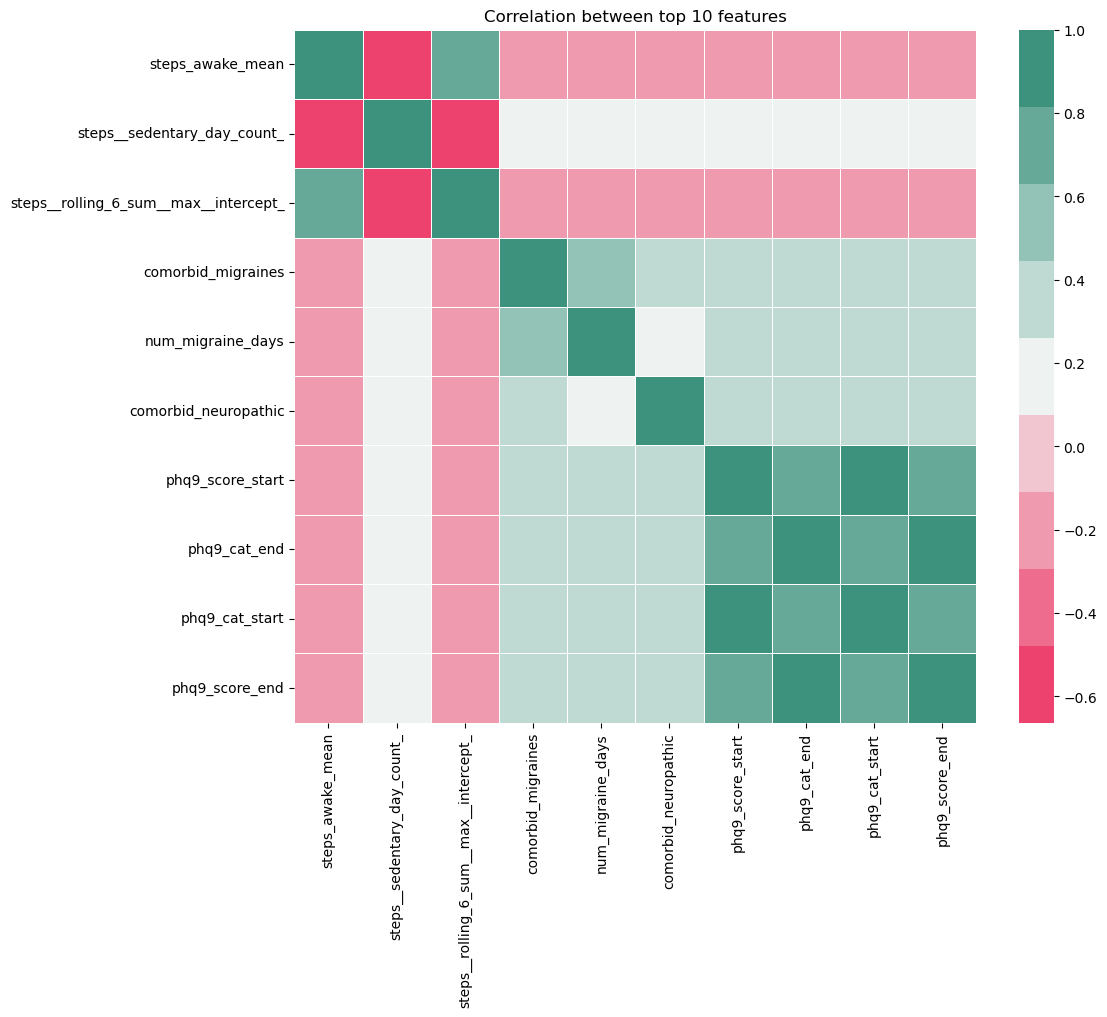

In [19]:
corr_matrix = df.corr()
plt.figure(figsize=(11, 9))
sns.heatmap(corr_matrix, annot=False, cmap=sns.diverging_palette(2, 165, s=80, l=55, n=9), linewidths=0.5)
plt.title("Correlation between top 10 features")
plt.show()

In [20]:
correlation = df.corr()
print(correlation['phq9_score_end'].sort_values(ascending=False))

phq9_score_end                           1.000000
phq9_cat_end                             0.968794
phq9_score_start                         0.760341
phq9_cat_start                           0.735872
comorbid_migraines                       0.339311
comorbid_neuropathic                     0.320740
num_migraine_days                        0.287335
steps__sedentary_day_count_              0.230478
steps_awake_mean                        -0.203874
steps__rolling_6_sum__max__intercept_   -0.209563
Name: phq9_score_end, dtype: float64


## Analyzing correlations between label and features

Use original dataset with PCA removed features (53 in total)

In [21]:
df = df_reduced.copy()

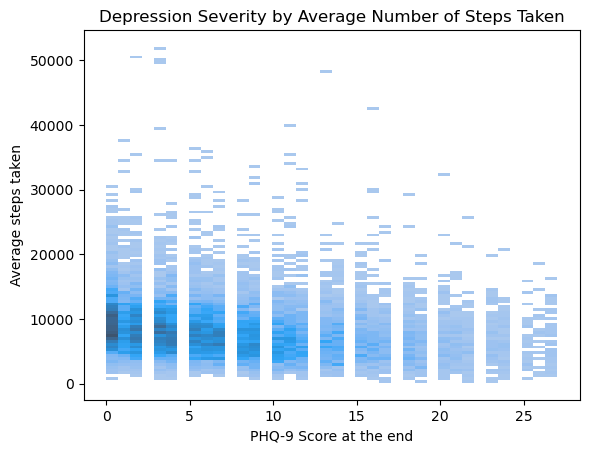

In [22]:
sns.histplot(data=df, x="phq9_score_end", y="steps_awake_mean")
plt.xlabel("PHQ-9 Score at the end")
plt.ylabel("Average steps taken")
plt.title("Depression Severity by Average Number of Steps Taken")
plt.show()

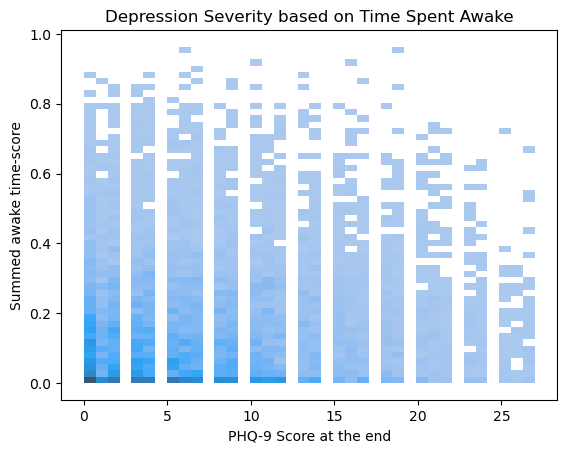

In [23]:

sns.histplot(data=df, x="phq9_score_end", y="sleep__awake__sum__score_")
plt.xlabel("PHQ-9 Score at the end")
plt.ylabel("Summed awake time-score")
plt.title("Depression Severity based on Time Spent Awake")
plt.show()

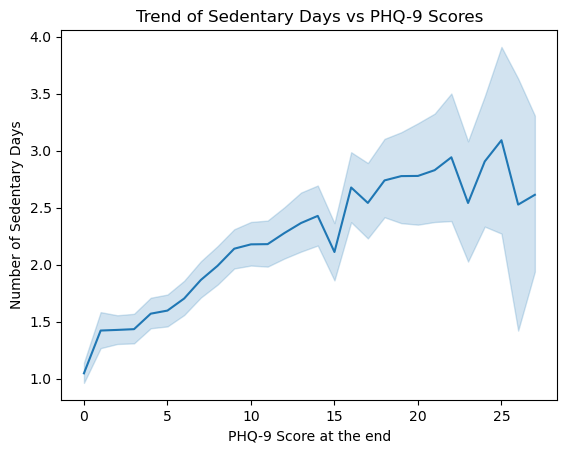

In [24]:
sns.lineplot(data=df, x="phq9_score_end", y="steps__sedentary_day_count_")
plt.xlabel("PHQ-9 Score at the end")
plt.ylabel("Number of Sedentary Days")
plt.title("Trend of Sedentary Days vs PHQ-9 Scores")
plt.show()

## SVM

In [25]:

X = df.drop(columns=['phq9_score_end'])
y = df['phq9_score_end']

scaler = StandardScaler()
X = scaler.fit_transform(X)


svr = SVR()

num_folds = 5 
param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.1, 1, 5, 10],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4]
}

halving_search = HalvingGridSearchCV(
    estimator=svr,
    param_grid=param_grid,
    scoring='r2',
    cv=num_folds,
    n_jobs=-1,
    verbose=1,
    factor=3
)

halving_search.fit(X, y)

best_model = halving_search.best_estimator_
print("Best Parameters:", halving_search.best_params_)


cv_results = cross_validate(best_model, X, y, cv=num_folds, scoring=['neg_mean_squared_error', 'r2'], return_train_score=False)
mean_mse = -cv_results['test_neg_mean_squared_error'].mean()
mean_r2 = cv_results['test_r2'].mean()

print(f"Best Model Mean MSE: {mean_mse}")
print(f"Best Model Mean R²: {mean_r2}")


n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 134
max_resources_: 10866
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 96
n_resources: 134
Fitting 5 folds for each of 96 candidates, totalling 480 fits
----------
iter: 1
n_candidates: 32
n_resources: 402
Fitting 5 folds for each of 32 candidates, totalling 160 fits
----------
iter: 2
n_candidates: 11
n_resources: 1206
Fitting 5 folds for each of 11 candidates, totalling 55 fits
----------
iter: 3
n_candidates: 4
n_resources: 3618
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 4
n_candidates: 2
n_resources: 10854
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best Parameters: {'C': 1, 'degree': 4, 'gamma': 'scale', 'kernel': 'linear'}
Best Model Mean MSE: 2.1030864825254874
Best Model Mean R²: 0.9418240460295271
